In [1]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
from img2vec_pytorch import Img2Vec
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle

## SVM model 

In [2]:
# Define the gender classes
gender_classes = ['Female', 'Male']

# Load the img2vec model (example: ResNet-18)
img2vec = Img2Vec(model='resnet-18')


C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Load the image data and extract features
X_train = []
y_train = []

In [4]:
for gender_class in gender_classes:
    image_paths = glob(f"balanced_train/{gender_class}/*.*")
    print(f"Number of images found for {gender_class}: {len(image_paths)}")

    for image_path in tqdm(image_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (264, 264))  # Resize to match the input size of the img2vec model
        image_pil = Image.fromarray(image)  # Convert NumPy array to PIL image
        
        # Extract features using img2vec model
        features = img2vec.get_vec(image_pil)
        
        X_train.append(features)
        y_train.append(gender_classes.index(gender_class))


Number of images found for Female: 1800


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [01:06<00:00, 27.20it/s]


Number of images found for Male: 1800


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [01:05<00:00, 27.32it/s]


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [6]:
# Splitting the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)


In [42]:
# Train the SVM model with a polynomial kernel
svm_model = SVC(probability=True)  # Polynomial kernel of degree 3 with default C value
svm_model.fit(x_train, y_train)

SVC(probability=True)

In [8]:
# Save the trained model
with open("mymodel12.pkl", "wb") as f:
    pickle.dump(svm_model, f)


In [9]:
# Load the trained model
with open("mymodel12.pkl", "rb") as f:
    svm_model_L = pickle.load(f)


### HyperParameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize the SVM classifier
svm_model = SVC(probability=True)

# Perform grid search cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
svm_val_predictions = best_model.predict(x_val)
svm_val_accuracy = accuracy_score(y_val, svm_val_predictions)
print(f"SVM Validation Accuracy with Best Model: {svm_val_accuracy*100:.2f}%")


Best Hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVM Validation Accuracy with Best Model: 93.23%


In [25]:
# Get the best model from grid search
best_svm_model = grid_search.best_estimator_


In [26]:
# Save the best model to a file
with open("model01.pkl", "wb") as f:
    pickle.dump(best_svm_model, f)

In [27]:
# Load the saved SVM model
with open("model01.pkl", "rb") as f:
    loaded_svm_model = pickle.load(f)

In [32]:
import cv2
import numpy as np
from PIL import Image
from img2vec_pytorch import Img2Vec

# Load the image and preprocess it
path_to_new_image = r"C:\Users\SOC\Downloads\Gender\bb.jpg"
new_img = Image.open(path_to_new_image)
new_img = new_img.resize((264, 264))  # Resize the image to match the input size of the model

# Initialize the Img2Vec model
img2vec = Img2Vec()

# Extract features for the new image
new_image_features = img2vec.get_vec(new_img).reshape(1, -1)

# Predict the class label using the loaded SVM model
predicted_class_index = loaded_svm_model.predict(new_image_features)[0]
predicted_class = potato_classes[predicted_class_index]

print("The predicted class for the new image is:", predicted_class)


The predicted class for the new image is: Female


### Before hyperparameter tuning 

In [43]:
# Evaluate the SVM model on the training set  without hyperparameter 
svm_train_predictions1 = svm_model.predict(x_train)
svm_train_accuracy1 = accuracy_score(y_train, svm_train_predictions)
print(f"SVM Training Accuracy: {svm_train_accuracy*100:.2f}%")

SVM Training Accuracy: 96.53%


In [44]:
# Evaluate the SVM model on the validation set
svm_val_predictions1 = svm_model.predict(x_val)
svm_val_accuracy1 = accuracy_score(y_val, svm_val_predictions)
print(f"SVM Validation Accuracy: {svm_val_accuracy*100:.2f}%")


SVM Validation Accuracy: 93.23%


In [45]:
# Evaluate the SVM model on the test set
svm_test_predictions1 = svm_model.predict(x_test)
svm_test_accuracy1 = accuracy_score(y_test, svm_test_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy*100:.2f}%")


SVM Test Accuracy: 95.83%


In [46]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, svm_test_predictions1))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.96      0.97      0.97        72

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



### After hyperparameter tuning


In [36]:
# Evaluate the SVM model on the training set  without hyperparameter 
svm_train_predictions = loaded_svm_model.predict(x_train)
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)
print(f"SVM Training Accuracy: {svm_train_accuracy*100:.2f}%")

SVM Training Accuracy: 96.53%


In [37]:
# Evaluate the SVM model on the validation set
svm_val_prediction =  loaded_svm_model.predict(x_val)
svm_val_accuracy = accuracy_score(y_val, svm_val_predictions)
print(f"SVM Validation Accuracy: {svm_val_accuracy*100:.2f}%")

SVM Validation Accuracy: 93.23%


In [39]:
# Evaluate the SVM model on the test set
svm_test_predictions =  loaded_svm_model.predict(x_test)
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy*100:.2f}%")

SVM Test Accuracy: 95.83%


In [41]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, svm_test_predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        72
           1       0.95      0.97      0.96        72

    accuracy                           0.96       144
   macro avg       0.96      0.96      0.96       144
weighted avg       0.96      0.96      0.96       144



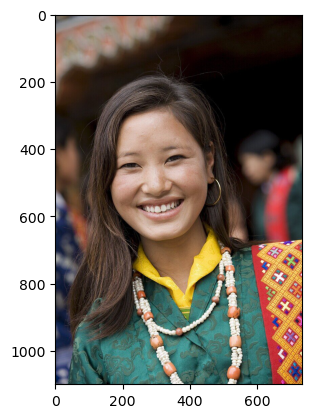

C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The predicted image is: Female


In [50]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from img2vec_pytorch import Img2Vec
import pickle


# Load the image and preprocess it
path = r"C:\Users\SOC\Downloads\Gender\bb.jpg"
img = image.load_img(path) 
plt.imshow(img) 
plt.show()

# Convert the PIL Image to a NumPy array
img_array = image.img_to_array(img)

# Resize the image
img_resized = img.resize((264, 264))

# Initialize the Img2Vec model
img2vec = Img2Vec()

# Extract features using img2vec model
features = img2vec.get_vec(img_resized)

# Reshape the features to match the expected input size of the SVM model
features = features.reshape(1, -1)

gender_classes = ['Female', 'Male']

# Predict the class label using the loaded SVM model
predicted_class_index = loaded_svm_model.predict(features)[0]
predicted_class = gender_classes[predicted_class_index]

print("The predicted image is:", predicted_class)



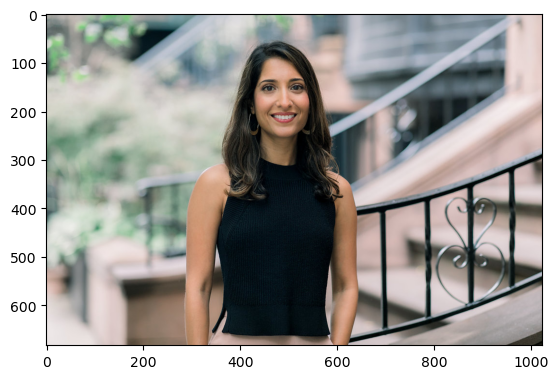

C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The predicted image is: Female


In [51]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from img2vec_pytorch import Img2Vec
import pickle


# Load the image and preprocess it
path = r"C:\Users\SOC\Downloads\Gender\12.jpg"
img = image.load_img(path) 
plt.imshow(img) 
plt.show()

# Convert the PIL Image to a NumPy array
img_array = image.img_to_array(img)

# Resize the image
img_resized = img.resize((264, 264))

# Initialize the Img2Vec model
img2vec = Img2Vec()

# Extract features using img2vec model
features = img2vec.get_vec(img_resized)

# Reshape the features to match the expected input size of the SVM model
features = features.reshape(1, -1)

gender_classes = ['Female', 'Male']

# Predict the class label using the loaded SVM model
predicted_class_index = loaded_svm_model.predict(features)[0]
predicted_class = gender_classes[predicted_class_index]

print("The predicted image is:", predicted_class)


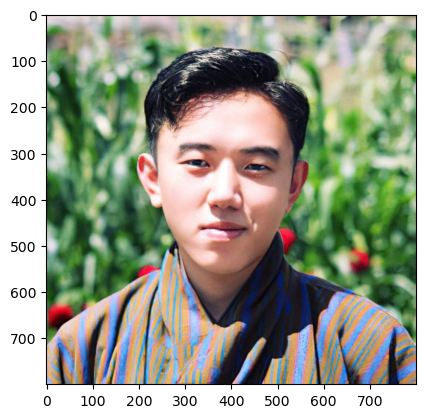

C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SOC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The predicted image is: Male


In [52]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from img2vec_pytorch import Img2Vec
import pickle


# Load the image and preprocess it
path = r"C:\Users\SOC\Downloads\Gender\1.jpeg"
img = image.load_img(path) 
plt.imshow(img) 
plt.show()

# Convert the PIL Image to a NumPy array
img_array = image.img_to_array(img)

# Resize the image
img_resized = img.resize((264, 264))

# Initialize the Img2Vec model
img2vec = Img2Vec()

# Extract features using img2vec model
features = img2vec.get_vec(img_resized)

# Reshape the features to match the expected input size of the SVM model
features = features.reshape(1, -1)

gender_classes = ['Female', 'Male']

# Predict the class label using the loaded SVM model
predicted_class_index = loaded_svm_model.predict(features)[0]
predicted_class = gender_classes[predicted_class_index]

print("The predicted image is:", predicted_class)
